<a href="https://colab.research.google.com/github/joynaomi81/GLUE-Benchmarking-on-Bert-Model/blob/main/GLUE_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from datasets import load_dataset


In [2]:
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00


In [3]:
#Load the model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Load dataset(GLUE)
task = "sst2"
dataset = load_dataset("glue", task)

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
#Preprocess the dataset
def Preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)
encoded_dataset = dataset.map(Preprocess_function, batched=True)
# Load evaluation metric
metric = evaluate.load("glue", task)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [6]:
# Define a function compute metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Create a DataCollator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Prepare evaluation arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    do_train=False,
    do_eval=True
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Run evaluation
results = trainer.evaluate()
print(results)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: joynaomi81 (joynaomi81-friendnpal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.725762128829956, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.5091743119266054, 'eval_runtime': 2.1997, 'eval_samples_per_second': 396.42, 'eval_steps_per_second': 6.365}


Filtered Results for Graph:                         Metric     Value
0  eval_model_preparation_time  0.002800
1                eval_accuracy  0.509174


/tmp/ipython-input-2641294970.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=results_df, palette="viridis")


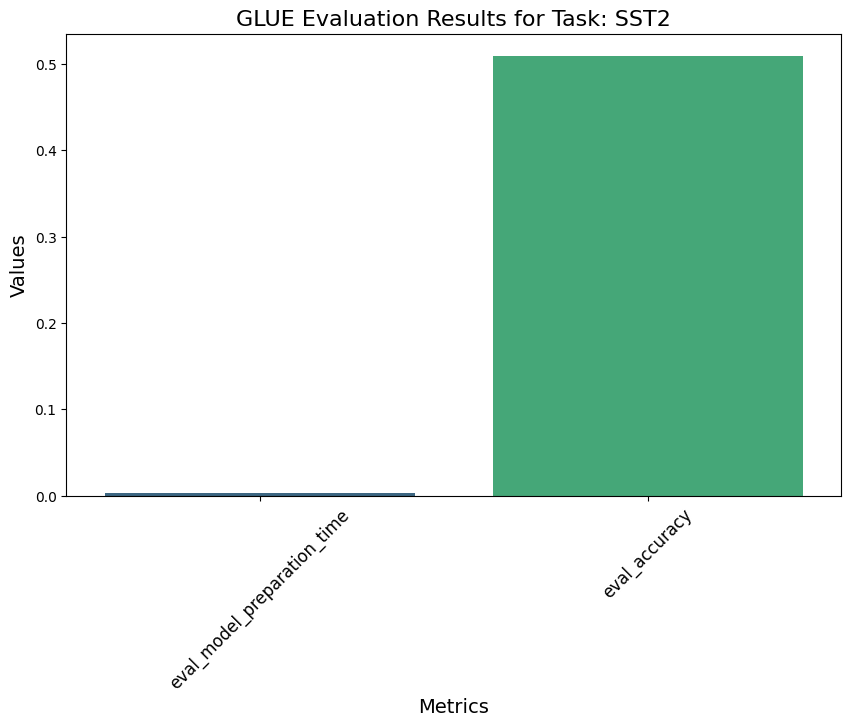

In [11]:
#Filter GLUE specific Metric
excluded_metrics = ["eval_loss", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "eval_model_prepare_time"]
glue_metrics = {k: v for k, v in results.items() if k not in excluded_metrics}

# Convert GLUE metrics to a DataFrame for visualization
results_df = pd.DataFrame.from_dict(glue_metrics, orient="index", columns=["Value"])
results_df = results_df.reset_index()
results_df.columns = ["Metric", "Value"]
print("Filtered Results for Graph:", results_df)

# Plot the GLUE metrics
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=results_df, palette="viridis")
plt.title(f"GLUE Evaluation Results for Task: {task.upper()}", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()
